# BARF Plan according to Nadine Wolf - Das BARF Buch

In [1]:
import pandas as pd
from gamspy import Set, Parameter, Variable, Equation, Model, Container
from gamspy import Sum, Sense
import BARF_class as bc

## Data
### Planning Horizon
- `weeks`: number of weeks to account for

In [2]:
weeks = 6

### Daily Food Demand
The daily food demand is determined by three components: 
- body weight (`weight`)
- base food ratio (`perc`)
- activity level (`activity`).

The body weight represents the targeted and ideal body weight of the dog. The base food ratio is usually calculated with 2% from the optimal body weight. The activity level is usually set as follows:

| Activity per day | Factor |
| --- | --- |
| <2 h | 1 |
| 2-3 h | 1.25 |
| 3-4 h | 1.5 |
| 4-5 h | 1.75 |
| 5-6 h | 2.5 |
| >6 h | 2.5 | 

A neutered dog requires less food. Usually the activity level is set to 0.9 for neutered dogs.

On a side note: The activity level can vary from dog to dog. Adjust the activity level by regularly checking the body weight until you find a configuration where the dog remains around the optimal weight.

In [3]:
weight = 35
perc =  0.02 # percent of body weight 
activity = 1 # dog activity level 

daylydemand = weight * perc * activity * 1000
weeklydemand = daylydemand * 7

print('Daily food demand:', round(daylydemand), 'g')
print('Weekly food demand:', round(weeklydemand), 'g')

Daily food demand: 700 g
Weekly food demand: 4900 g


### Fat
Fat is the main energy source for a dog. The optimal amount of fat in a food ratio is between 11% and 15%.

In [4]:
fat_lb = 0.11 # lower bound of fat
fat_ub = 0.15 # upper bound of fat

### Food Components
An optimal BARF ration withouth grain consists of 80% animal components (`Meat`) and 20% plant-based components (`Veg & Fruit`). 


In [5]:
modules_share = {
    'Meat': 0.8,
    'Veg & Fruit': 0.2
}

The meat share is ideally composed as:
- 50% muscle meat
- 20% pansen / blättermagen
- 15% intestinals (heart, liver, kidney, spleen)
- 15% raw flesh bones (not bare bones - rather 1/2 bone, 1/2 meat) - RFK

If the dog does not tolerate pansen, you substitute with muscle meat.

RFK can be hard and soft. Hard bones are, e.g., sternum and rips of lamb and cow. Soft bones are, e.g., spine, neck, and chest of chicken and rabbit. 

Some dogs tend to throw up bigger pieces of hard bones at night. Soft bones are easier to digest. If you only feed soft bones the RFK share is increased to 20% and the muscle share decreased to 45%. 

The vegtable share is ideally composed as:
- 75% vegetables
- 25% fruits

In [6]:
component_share = pd.DataFrame([
    ['Muscle', 0.5],
    ['Intestinals', 0.15],
    ['Pansen', 0.2],
    ['RFK', 0.15],
    ['Vegetable', 0.75],
    ['Fruit', 0.25]
], columns=['Component', 'Share']).set_index('Component')

# check if components add up to 100%
bc.check_components(component_share)

# calc demand
components_pie_chart, demand_df = bc.calc_demand(modules_share, component_share, weeklydemand)

demand_df

,Share
Component,
Muscle,1960.0
Intestinals,588.0
Pansen,784.0
RFK,588.0
Vegetable,735.0
Fruit,245.0


<Axes: title={'center': 'Components'}, ylabel='Share'>

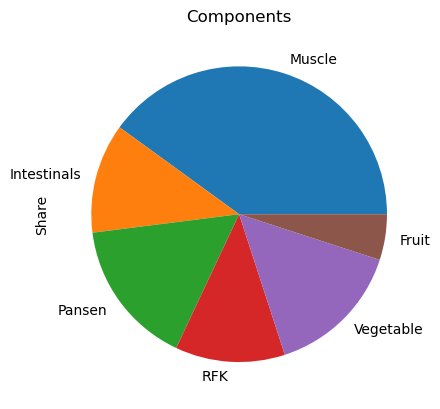

In [7]:
# plot components
components_pie_chart.plot(kind='pie', y='Share', title='Components', legend=False)

### Intestinals
The optimal composition of intestinals:
- $\frac{2}{5}$ liver
- $\frac{1}{5}$ heart
- $\frac{1}{5}$ kidney
- $\frac{1}{5}$ spleen

<Axes: title={'center': 'Intestinals'}, ylabel='Share'>

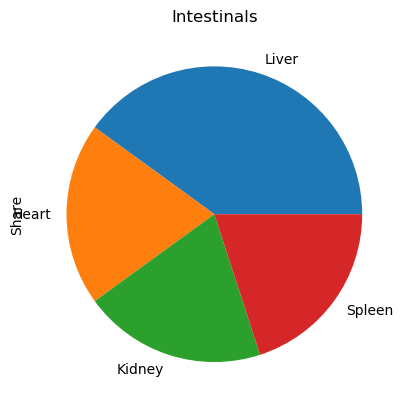

In [8]:
intestinal_share_df = pd.DataFrame([
    ['Liver', 2/5],
    ['Heart', 1/5],
    ['Kidney', 1/5],
    ['Spleen', 1/5]
], columns=['Intestinal', 'Share']).set_index('Intestinal')
intestinal_share_df.plot(kind='pie', y='Share', title='Intestinals', legend=False)

### Fish
Fisch ist ein wichtiger Bestandteil der BARF Ration, um den Vitamin D Haushalt zu decken. Es wird empfohlen 1x pro Woche den Muskelfleischanteil durch Fisch zu ersetzen. Dazu eignen sich insbesondere Vitamin D haltige Fische wie Sprotten, Hering, Lachs, Sardellen und Forelle. 

In [9]:
component_share

,Share
Component,
Muscle,0.50
Intestinals,0.15
Pansen,0.20
RFK,0.15
Vegetable,0.75
Fruit,0.25


In [10]:
weekly_fish_amount = round(daylydemand * modules_share['Meat'])
print(f'The suggested amount of fish per week is {weekly_fish_amount}g.')

The suggested amount of fish per week is 560g.


You can manually adjust the amount of fish if desired. If you do not want to feed fish, set `weekly_fish_amount` to 0. In this case, remember to substitute fish with Lebertran to supply enough vitamin D. 

In [11]:
# adjusted fish amount
weekly_fish_amount = 500

## Products

In [12]:
products = [
    # Pferd
    bc.Product(name='Pferdefleisch', category='Horse', volume=500, price=3.89, muscle=1, fat=0.23),
    bc.Product(name='PferdefleischwuerfelFettig', category='Horse', volume=2000, price=13.99, muscle=1, fat=0.254),
    bc.Product(name='PferdefleischKlumpen', category='Horse', volume=2000, price=17.49, muscle=1, fat=0.05),
    bc.Product(name='Pferdeherz', category='Horse', volume=500, price=4.98, heart=1, fat=0.12),
    bc.Product(name='Pferdemilz', category='Horse', volume=500, price=5.69, spleen=1, fat=0.051),
    bc.Product(name='Pferdeniere', category='Horse', volume=500, price=4.29, kidney=1, fat=0.085),
    bc.Product(name='Pferdeleber', category='Horse', volume=500, price=4.29, liver=1, fat=0.04),
    bc.Product(name='Pferdefett', category='Horse', volume=500, price=3.48, muscle=1, fat=0.91),
    bc.Product(name='Pferdeknochenbrei', category='Horse', volume=250, price=3.19, rfk=1, fat=0.135),
    # Rind
    # bc.Product(name='Kalbsfleischabschnitte', category='Beef', volume=500, price=3.29, muscle=1, fat=0.35),
    # bc.Product(name='RindfleischamStueck', category='Beef', volume=100, price=7.88, muscle=1, fat=0.12),
    # bc.Product(name='RindfleischKlumpen', category='Beef', volume=2000, price=16.99, muscle=1, fat=0.12),
    # bc.Product(name='Rindermuskelfleischwuerfel', category='Beef', volume=500, price=4.29, muscle=1, fat=0.09),
    # bc.Product(name='Rinderfett', category='Beef', volume=500, price=2.98, muscle=1, fat=0.91),
    # bc.Product(name='RinderherzKlumpen', category='Beef', volume=2000, price=10.49, heart=1, fat=0.05),
    # bc.Product(name='Rinderherzwuerfel', category='Beef', volume=500, price=3.59, heart=1, fat=0.05),
    # bc.Product(name='RinderniereAmStueck', category='Beef', volume=500, price=2.49, kidney=1, fat=0.085),
    # bc.Product(name='RindermilzWuerfel', category='Beef', volume=500, price=2.39, spleen=1, fat=0.051),
    # bc.Product(name='RinderleberAmStueck', category='Beef', volume=500, price=2.49, liver=1, fat=0.085),
    # # bc.Product(name='RinderLeberNierenMilzMix', category='Beef', volume=500, price=2.78, liver=0.5, kidney=0.25, spleen=0.25, fat=0.039),
    # bc.Product(name='Rinderpansen', category='Beef', volume=500, price=1.98, pansen=1, fat=0.05),
    # bc.Product(name='Rinderblaettermagen', category='Beef', volume=500, price=2.08, pansen=1, fat=0.05),
    # # Lamm
    # bc.Product(name='Lammbauchlappen', category='Lamb', volume=1000, price=10.19, muscle=1, fat=0.3),
    # bc.Product(name='Lammfleisch', category='Lamb', volume=500, price=4.38, muscle=1, fat=0.048),
    # bc.Product(name='Lammfleischabschnitte', category='Lamb', volume=500, price=5.29, muscle=1, fat=0.15),
    # bc.Product(name='Lammfett', category='Lamb', volume=500, price=3.98, muscle=1, fat=0.91),
    bc.Product(name='Lammpansen', category='Lamb', volume=500, price=3.88, pansen=1, fat=0.14),
    # bc.Product(name='LammleberStuecke', category='Lamb', volume=500, price=3.28, liver=1, fat=0.05),
    # bc.Product(name='LammniereStuecke', category='Lamb', volume=500, price=3.78, kidney=1, fat=0.06),
    # bc.Product(name='LammmilzStuecke', category='Lamb', volume=500, price=4.68, spleen=1, fat=0.027),
    # # bc.Product(name='LamminnereienMix', category='Lamb', volume=250, price=2.08, heart=0.4, kidney=0.3, liver=0.3, fat=0.07),
    # bc.Product(name='LammherzStuecke', category='Lamb', volume=500, price=4.18, heart=1, fat=0.05),
    # # Wild
    # bc.Product(name='WildfleischKlumpen', category='Deer', volume=2000, price=16.99, muscle=1, fat=0.16),
    # bc.Product(name='Elchfleisch', category='Deer', volume=500, price=3.69, muscle=1, fat=0.16),
    # # Geflügel
    # # bc.Product(name='Truthahnfleisch', category='Chicken', volume=500, price=2.98, muscle=1, fat=0.07), # zu gewolft 
    # bc.Product(name='Haehnchenherz', category='Chicken', volume=500, price=3.49, heart=1, fat=0.05),
    # bc.Product(name='Huehnerfett', category='Chicken',  volume=1000, price=3.69, muscle=1, fat=0.995),
    # bc.Product(name='Huehnerfleisch', category='Chicken', volume=1000, price=8.99, muscle=1, fat=0.142),
    # bc.Product(name='HuehnerfleischStuecke', category='Chicken', volume=500, price=3.79, muscle=1, fat=0.142),
    # bc.Product(name='Gefluegelinnereien-Mix', category='Chicken', volume=500, price=2.98, heart=0.5, muscle=0.5, fat=0.05),
    # # Fish
    bc.Product(name='Lachs', category='Fish', volume=500, price=2.98, fish=1, fat=0.075),
    # # Knochen
    # bc.Product(name='Kaninchenkarkasse', category='Rabbit', volume=1000, price=5.49, rfk=1, fat=0.15),
    # # bc.Product(name='Rinderbrustbein', category='Beef', volume=1000, price=3.68, rfk=1, fat=0.14),
    # # bc.Product(name='Lammrippe', category='Lamb', volume=1000, price=6.53, rfk=1, fat=0.24),
    # # bc.Product(name='Lammbrustbein', category='Lamb', volume=1000, price=5.78, rfk=1, fat=0.17),
    # # bc.Product(name='Wildrippe', category='Deer', volume=1000, price=5.68, rfk=1, fat=0.24),
    # bc.Product(name='Huehnerhaelse', category='Chicken', volume=1000, price=3.28, rfk=1, fat=0.22),
    # bc.Product(name='SpareribsVomPferd', category='Horse', volume=1000, price=7.48, rfk=1, fat=0.16),
    # Vegetable & Fruit
    bc.Product(name='Vegetables', category='Vegetables', volume=1, price=0.001, vegetable=1, fat=0),
    bc.Product(name='Fruit', category='Fruits', volume=1, price=0.001, fruit=1, fat=0)
] 

df, content_components_df, intest_components_df = bc.process_products(products, component_share)

## Inventory
Account for the products you have in your inventory.

In [13]:
bc.add_inventory(df, 'PferdefleischwuerfelFettig', 3*2000)
bc.add_inventory(df, 'Pferdeknochenbrei', 200)
bc.add_inventory(df, 'Pferdemilz', 250)
bc.add_inventory(df, 'Pferdeniere', 250)

df.sort_values(by='Price [€/kg]').set_index('Name')

,Category,Inventory,Price [€/kg],Price,Volume,Fat
Name,,,,,,
Vegetables,Vegetables,0,1.00,0.001,1,0.000
Fruit,Fruits,0,1.00,0.001,1,0.000
Lachs,Fish,0,5.96,2.980,500,0.075
Pferdefett,Horse,0,6.96,3.480,500,0.910
PferdefleischwuerfelFettig,Horse,6000,7.00,13.990,2000,0.254
Lammpansen,Lamb,0,7.76,3.880,500,0.140
Pferdefleisch,Horse,0,7.78,3.890,500,0.230
Pferdeniere,Horse,250,8.58,4.290,500,0.085
Pferdeleber,Horse,0,8.58,4.290,500,0.040


Validate input data

In [14]:
assert 'Fish' in df['Category'].values, 'No fish in products'
for c in component_share.index:
    assert content_components_df[['Component', 'Share']].groupby('Component').sum().loc[c]['Share'] > 0, f'No {c} in products'

## Model
### Symbols

In [15]:
m = Container()

# Sets
p = m.addSet('p', description='Products', records=df['Name'])
c = m.addSet('c', description='Components', records=component_share.index)
i = m.addSet('i', description='Intestinals', records=intestinal_share_df.index)

GREENS = m.addSet('GREENS', p, records=df[(df['Category'] == 'Fruits') | (df['Category'] == 'Vegetables')][['Name', 'Category']])
FISH = m.addSet('FISH', p, records=df[df['Category'] == 'Fish'][['Name', 'Category']])

# create parameters
price = m.addParameter('price', p, records=df[['Name', 'Price']], description="price of product p")

volume = m.addParameter('volume', p, records=df[['Name', 'Volume']], 
                        description='volume of product p')

inventory = m.addParameter('inventory', p, records=df[['Name', 'Inventory']], 
                           description='inventory of product p')

fat = m.addParameter('fat', p, records=df[['Name', 'Fat']], description='fat share of product p')

demand = m.addParameter('demand', c, records=demand_df.reset_index(), description='demand for each component')

content_components = m.addParameter('content_components', [c, p], records=content_components_df, 
                                    description='components of product p')

intestinal_components = m.addParameter('intestinal_components', [i, p], records=intest_components_df,
                                       description='intestinal components of product p')

intestinal_share = m.addParameter('intestinal_share', i, records=intestinal_share_df.reset_index(),
                           description='intestinal share')

# create scalars
m.addParameter('weeks', records=weeks, description="number of weeks")
m.addParameter('weeklydemand', records=weeklydemand, description="weekly demand")
m.addParameter('weight', records=weight, description="dogs desired body weight")
m.addParameter('perc', records=perc, description="percent of body weight")
m.addParameter('activity', records=activity, description="dog activity level")
m.addParameter('fatlb', records=fat_lb, description="lower bound on fat")
m.addParameter('fatub', records=fat_ub, description="upper bound on fat")
m.addParameter('fish_amount', records=weekly_fish_amount, description="amount of fish")

# create variables
F = m.addVariable('F', description='Objective function value')
X = m.addVariable('X', 'positive', p, description='Amount of product p')
Y = m.addVariable('Y', 'integer', p, description='Auxiliary variable to avoid odd numbers for X')
Z = m.addVariable('Z', 'integer', p, description='Number of packs to buy from product p')

### Equations

Ziel ist, für eine vorgegebene Anzahl an Wochen die optimale Ration an Futter für den Hund zusammenzustellen. Dabei gilt es sowohl die Gesamtmenge an Futter als auch die AufDas Ziel ist die optimale Ration an Futter für den Hund zusammenzustellen muss zunächst sichergestellt werden, dass die Gesamtfuttermenge berücksichtigt wird. Die Gesamtfuttermenge für eine Woche beträgt `weeklydemand`.  

The amount of food per week has to be equal to the weekly demand

In [16]:
objective = Equation(m, name='objective', description='Objective function')
totalLB = Equation(m, name='totalLB', description='Minimum total quantity')
totalUB = Equation(m, name='totalUB', description='Maximum total quantity')
components = Equation(m, name='components', domain=[c], description='Account for the quantity of each component')
intests = Equation(m, name='intests', domain=[i], description='Account for the quantity of each intestinal component')
fish_day = Equation(m, name='fish_day', description='Include one fish day')
fatLB = Equation(m, name='fat_lb',  description='Account for the minimal amount of fat')
fatUB = Equation(m, name='fat_ub',  description='Account for the maximal amount of fat')
buy = Equation(m, name='buy', domain=[p], description='Determine the number of packs to buy')
rounding = Equation(m, name='rounding', domain=[p], description='Prohibit uneven amounts')

objective.definition = F == Sum(p, (price[p] / volume[p]) * X[p]) + Sum(p, price[p] * Z[p])
totalLB.definition = Sum(p, X[p]) >= 0.98 * weeklydemand * weeks
totalUB.definition = Sum(p, X[p]) <= 1.02 * weeklydemand * weeks
components[c] = Sum(p, content_components[c, p] * X[p]) >= weeks * demand[c] - 26
intests[i] = Sum(p, intestinal_components[i, p] * X[p]) >= intestinal_share[i] * weeks * demand['Intestinals']
fish_day.definition = Sum(FISH[p], X[p]) == weekly_fish_amount * weeks
fatLB.definition = Sum(p, fat[p] * X[p]) >= fat_lb * Sum(p, X[p])
fatUB.definition = Sum(p, fat[p] * X[p]) <= fat_ub * Sum(p, X[p])
buy[p] = inventory[p] + volume[p] * Z[p] >= X[p]
rounding[p] = X[p] == 50 * Y[p]


In [17]:
barf = Model(
    m,
    name="BARF",
    equations=m.getEquations(),
    problem="MIP",
    sense=Sense.MIN,
    objective=F,
)

barf.solve()

# Review Results
Amount of Products

In [18]:
X.records.loc[X.records['level'] > 1][['p', 'level']]

,p,level
1,PferdefleischwuerfelFettig,7850.0
3,Pferdeherz,750.0
4,Pferdemilz,750.0
5,Pferdeniere,750.0
6,Pferdeleber,1450.0
7,Pferdefett,900.0
8,Pferdeknochenbrei,3550.0
9,Lammpansen,4700.0
10,Lachs,3000.0
11,Vegetables,4400.0


Number of packs to buy of product

In [19]:
Z.records.loc[Z.records['level'] > 0][['p', 'level']]

,p,level
1,PferdefleischwuerfelFettig,1.0
3,Pferdeherz,2.0
4,Pferdemilz,1.0
5,Pferdeniere,1.0
6,Pferdeleber,3.0
7,Pferdefett,2.0
8,Pferdeknochenbrei,14.0
9,Lammpansen,10.0
10,Lachs,6.0
11,Vegetables,4400.0


## BARF Ratio Statistics

In [20]:
final_percent = X.records['level'].sum() / (7 * weeks) / (weight * 1000) * 100
tar_percent = activity * perc * 100
total_cost = round((X.records['level'] / 1000 * df['Price [€/kg]']).sum(), 2)
daily_cost = total_cost / (7 * weeks)
fat = (X.records['level'] * df['Fat']).sum() / X.records['level'].sum() * 100
r = pd.DataFrame({
    'Index': ['Final Percent [%]', 'Targeted Percent [%]', 'Total Cost [€]', 'Daily Cost [€]', 'Fat [%]', 'Daily Demand [g]'],
    'Column': [final_percent, tar_percent, total_cost, daily_cost, fat, daylydemand]
}).round(2)
r

,Index,Column
0,Final Percent [%],2.01
1,Targeted Percent [%],2.00
2,Total Cost [€],201.60
3,Daily Cost [€],4.80
4,Fat [%],14.98
5,Daily Demand [g],700.00


## Supplements
Don't forget to add salt, iodine, and oil.

### Salt:
1-2 Pinches per week

### Jod (Seealgenmehl/Ascophyllum nodosum):
- [Seealgen Blog](https://www.barf-check.de/seealgen-bei-barf/)
- [Seealgen Rechner](https://www.barf-kultur.de/Seealgenrechner)

### Oil:
- 1ml oil per 100g food (1 tee spoon = 5 ml)
- Salmon oil, Linseed oil, and Hemp seed oil are well balanced oils
- Stabilize oil with Vitamin E (10IE pro ml oil)
- [Öl Blog](https://www.der-barf-blog.de/2015/11/barf-oel.html)